In [92]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from itertools import islice
from collections import OrderedDict

from preprocessing.numeric import *
from preprocessing.tokens import *

RANDOM_SEED = 2
tf.random.set_seed(RANDOM_SEED)

tf.__version__, tf.keras.__version__

In [104]:
train = tf.data.experimental.make_csv_dataset("data/train_small.tsv",
                                           field_delim="\t",
                                           batch_size=1_000,
#                                            compression_type="GZIP",
                                           label_name="Click",
                                           num_epochs=1)

test = tf.data.experimental.make_csv_dataset("data/test.tsv",
                                           field_delim="\t",
                                           batch_size=10_000,
                                           label_name="Click",
                                           num_epochs=1)

NUMERIC_FEATURES = ["Depth", "Position", "Gender", "Age", "UserID", "AdvertiserId"]
TOKENS_FEATURES = ["AdKeyword_tokens", "AdTitle_tokens", "AdDescription_tokens", "Query_tokens"]

---
#### Numeric features

In [105]:
train = train\
    .map(PackNumericFeatures(NUMERIC_FEATURES), deterministic=True)\
    .map(Normalize(NUMERIC_FEATURES), deterministic=True)

test = test\
    .map(PackNumericFeatures(NUMERIC_FEATURES), deterministic=True)\
    .map(Normalize(NUMERIC_FEATURES), deterministic=True)

---
#### Sequence of tokens features
AdKeyword_tokens, AdTitle_tokens, AdDescription_tokens, Query_tokens

Jak stworzyć słownik do modelu?

In [106]:
n_words = 2_000
max_length = 5

train = train\
    .map(Tokenize("AdKeyword_tokens", n_words, max_length), deterministic=True)

test = test\
    .map(Tokenize("AdKeyword_tokens", n_words, max_length), deterministic=True)

---
#### Model

In [107]:
EMBEDDING_DIM = 12

embedding_layer = tf.keras.layers.Embedding(input_dim=n_words, output_dim=EMBEDDING_DIM, mask_zero=False, input_length=max_length)

x_num_input = tf.keras.Input(shape=(6, ), name="numeric")
x_num = tf.keras.layers.Dense(512, activation="relu")(x_num_input)

x_emb_input = tf.keras.Input(shape=(max_length), name="AdKeyword_tokens")  # model doesn't work with ragged tensor
x_emb = embedding_layer(x_emb_input)
x_emb = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=False, name="Average"))(x_emb)

x_emb = tf.keras.layers.Reshape([EMBEDDING_DIM])(x_emb)

x = tf.keras.layers.Concatenate(axis=-1)([x_num, x_emb])

feedforward = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="prediction"),
])

output = feedforward(x)

model = tf.keras.Model(inputs=[x_num_input, x_emb_input], outputs=output, name="Adclick")

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [108]:
model.summary()

Model: "Adclick"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
AdKeyword_tokens (InputLayer)   [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 5, 12)        24000       AdKeyword_tokens[0][0]           
__________________________________________________________________________________________________
numeric (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 12)           0           embedding_15[0][0]               
____________________________________________________________________________________________

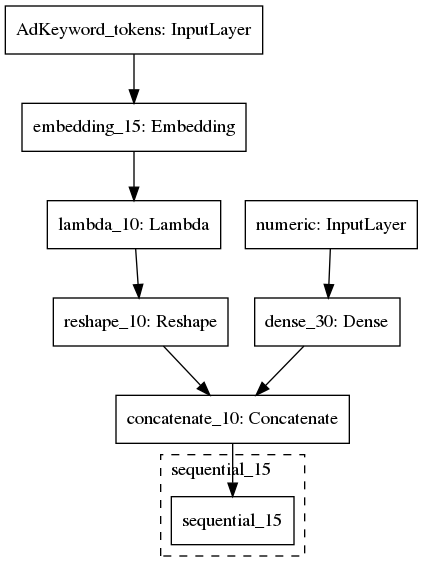

In [109]:
tf.keras.utils.plot_model(model, expand_nested=True)

In [111]:
def schedule(epoch, lr):
    print(epoch)
    if epoch == 0:
        return 0.1
    elif epoch == 1:
        return 0.01
    else:
        return 0.001
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

history = model.fit(train, validation_data=test, epochs=2, callbacks=[scheduler])

0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/2
100/100 [==============================] - 29s 291ms/step - loss: 0.1918 - accuracy: 0.9507 - auc: 0.6662 - val_loss: 0.1992 - val_accuracy: 0.9524 - val_auc: 0.6193 - lr: 0.1000
1

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/2
100/100 [==============================] - 30s 296ms/step - loss: 0.1775 - accuracy: 0.9509 - auc: 0.7429 - val_loss: 0.1981 - val_accuracy: 0.9523 - val_auc: 0.6212 - lr: 0.0100
